# Disease Prediction Model based on Symptoms

This notebook implements a machine learning model that predicts diseases based on patient symptoms. The model provides predictions along with confidence scores to indicate the reliability of each prediction.

## 1. Import Required Libraries

Let's import all the necessary libraries for our disease prediction model.

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import warnings
import os
warnings.filterwarnings('ignore')

# Set NLTK data path to a directory we know we can write to
nltk_data_dir = os.path.join(os.path.expanduser('~'), 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Download required NLTK data with verification
def download_nltk_data():
    required_packages = ['punkt', 'stopwords', 'wordnet', 'omw-1.4']
    for package in required_packages:
        try:
            nltk.data.find(f'tokenizers/{package}' if package == 'punkt' 
                          else f'corpora/{package}' if package in ['stopwords', 'wordnet']
                          else package)
            print(f"'{package}' already downloaded")
        except LookupError:
            print(f"Downloading '{package}'...")
            nltk.download(package, download_dir=nltk_data_dir)
            print(f"'{package}' successfully downloaded")

download_nltk_data()

'punkt' already downloaded
'stopwords' already downloaded


[nltk_data] Downloading package wordnet to C:\Users\aadit\nltk_data...


'wordnet' successfully downloaded


[nltk_data] Downloading package omw-1.4 to C:\Users\aadit\nltk_data...


'omw-1.4' successfully downloaded


## 2. Load and Preprocess Data

Now we'll load our dataset and prepare it for training.

In [12]:
# Load the dataset
df = pd.read_csv('Symptom2Disease.csv')

# Display first few rows and basic information
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nFirst few rows:")
print("-" * 50)
print(df.head())

# Check unique diseases
print("\nUnique Diseases:")
print("-" * 50)
print(df['label'].unique())
print(f"\nTotal number of unique diseases: {len(df['label'].unique())}")

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.3+ KB
None

First few rows:
--------------------------------------------------
   Unnamed: 0      label                                               text
0           0  Psoriasis  I have been experiencing a skin rash on my arm...
1           1  Psoriasis  My skin has been peeling, especially on my kne...
2           2  Psoriasis  I have been experiencing joint pain in my fing...
3           3  Psoriasis  There is a silver like dusting on my skin, esp...
4           4  Psoriasis  My nails have small dents or pits in them, and...

Unique Diseases:
-------------------------------

## 3. Text Preprocessing and Vectorization

Let's clean our text data and convert it into numerical features that can be used by our machine learning model.

In [13]:
def preprocess_text(text):
    try:
        # Handle NaN or non-string inputs
        if pd.isna(text) or not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        try:
            # Tokenization
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback if NLTK data is not available
            tokens = text.split()
        
        # Remove punctuation and numbers
        tokens = [token for token in tokens if token not in string.punctuation and not token.isnumeric()]
        
        try:
            # Remove stopwords
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if token not in stop_words]
        except LookupError:
            print("Warning: Stopwords not available, skipping stopword removal")
        
        try:
            # Lemmatization
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        except LookupError:
            print("Warning: WordNet not available, skipping lemmatization")
        
        # Join tokens back into text
        return ' '.join(tokens)
    except Exception as e:
        print(f"Warning: Error processing text: {str(e)}")
        return ""

# Apply preprocessing to the text column with error handling
try:
    print("Starting text preprocessing...")
    df['processed_text'] = df['text'].apply(preprocess_text)
    print("Text preprocessing completed successfully!")
    
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=1000)
    X = tfidf.fit_transform(df['processed_text'])
    y = df['label']

    print("Shape of feature matrix:", X.shape)
    print("Number of features:", len(tfidf.get_feature_names_out()))
except Exception as e:
    print(f"Error during preprocessing or vectorization: {str(e)}")

Starting text preprocessing...
Text preprocessing completed successfully!
Shape of feature matrix: (1200, 1000)
Number of features: 1000
Text preprocessing completed successfully!
Shape of feature matrix: (1200, 1000)
Number of features: 1000


## 4. Train Test Split

Split our data into training and testing sets to evaluate our model's performance.

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (960, 1000)
Testing set shape: (240, 1000)


## 5. Model Building and Training

Create and train a Random Forest Classifier with probability estimation capabilities.

In [15]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Get probability scores for predictions
y_pred_proba = rf_model.predict_proba(X_test)

print("Model training completed!")

Model training completed!


## 6. Prediction Function with Confidence Score

Create a function that takes symptoms as input and returns predicted disease with confidence score.

In [16]:
def predict_disease(symptoms):
    # Preprocess the input symptoms
    processed_symptoms = preprocess_text(symptoms)
    
    # Transform the text using the fitted vectorizer
    symptoms_vector = tfidf.transform([processed_symptoms])
    
    # Get prediction and probability
    prediction = rf_model.predict(symptoms_vector)[0]
    probabilities = rf_model.predict_proba(symptoms_vector)[0]
    confidence = max(probabilities) * 100
    
    # Get top 3 predictions with their confidence scores
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    top_3_predictions = []
    
    for idx in top_3_indices:
        disease = rf_model.classes_[idx]
        prob = probabilities[idx] * 100
        top_3_predictions.append((disease, prob))
    
    return {
        'top_prediction': prediction,
        'confidence': confidence,
        'top_3_predictions': top_3_predictions
    }

## 7. Model Evaluation

Let's evaluate our model's performance using various metrics.

In [17]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Display detailed classification report
print("\nClassification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred))

# Calculate and display confusion matrix
print("\nConfusion Matrix:")
print("-" * 50)
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 97.08%

Classification Report:
--------------------------------------------------
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        11
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       0.79      0.92      0.85        12
                    Common Cold       1.00      1.00      1.00        12
                         Dengue       1.00      0.75      0.86        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00         7
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       0.92      1.00      0.96        11
                       Ja

## 8. Example Predictions

Let's test our model with some example symptoms and see the predictions with confidence scores.

In [18]:
# Test cases
test_symptoms = [
    "I have been experiencing a skin rash on my arms, legs, and torso. It is red, itchy, and covered in dry, scaly patches.",
    "I have a rash on my legs that is causing a lot of discomforts. It seems there is a cramp and I can see prominent veins on the calf.",
    "I have constipation and belly pain, and it's been really uncomfortable. I get chills every night, followed by a mild fever.",
    "I have been feeling extremely tired and weak, and I've been coughing a lot with difficulty breathing. My fever is very high."
]

print("Example Predictions:")
print("-" * 50)

for symptoms in test_symptoms:
    print("\nSymptoms:", symptoms)
    result = predict_disease(symptoms)
    
    print("\nTop Prediction:", result['top_prediction'])
    print(f"Confidence: {result['confidence']:.2f}%")
    
    print("\nTop 3 Possible Diseases:")
    for disease, prob in result['top_3_predictions']:
        print(f"- {disease}: {prob:.2f}%")
    print("-" * 50)

Example Predictions:
--------------------------------------------------

Symptoms: I have been experiencing a skin rash on my arms, legs, and torso. It is red, itchy, and covered in dry, scaly patches.

Top Prediction: Psoriasis
Confidence: 56.00%

Top 3 Possible Diseases:
- Psoriasis: 56.00%
- Chicken pox: 13.00%
- Dengue: 8.00%
--------------------------------------------------

Symptoms: I have a rash on my legs that is causing a lot of discomforts. It seems there is a cramp and I can see prominent veins on the calf.

Top Prediction: Varicose Veins
Confidence: 93.00%

Top 3 Possible Diseases:
- Varicose Veins: 93.00%
- drug reaction: 2.00%
- Psoriasis: 2.00%
--------------------------------------------------

Symptoms: I have constipation and belly pain, and it's been really uncomfortable. I get chills every night, followed by a mild fever.

Top Prediction: Typhoid
Confidence: 76.00%

Top 3 Possible Diseases:
- Typhoid: 76.00%
- Chicken pox: 13.00%
- allergy: 2.00%
-----------------

## 9. Understanding Model's Decision Process

Let's examine how our Random Forest model makes its decisions by:
1. Looking at feature importance
2. Visualizing the decision path for a prediction
3. Analyzing key terms that influence the predictions

Matplotlib is building the font cache; this may take a moment.


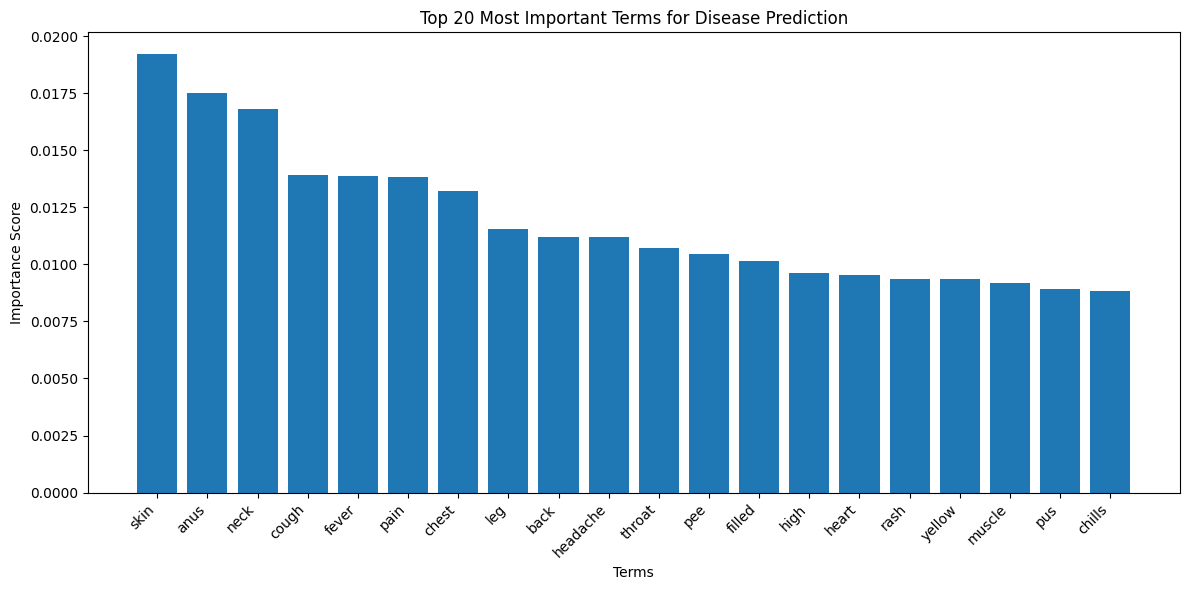


Top 20 Most Important Terms:
--------------------------------------------------
skin: 0.0192
anus: 0.0175
neck: 0.0168
cough: 0.0139
fever: 0.0139
pain: 0.0138
chest: 0.0132
leg: 0.0116
back: 0.0112
headache: 0.0112
throat: 0.0107
pee: 0.0105
filled: 0.0102
high: 0.0096
heart: 0.0095
rash: 0.0094
yellow: 0.0094
muscle: 0.0092
pus: 0.0089
chills: 0.0088


In [19]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': rf_model.feature_importances_
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Terms for Disease Prediction')
plt.xlabel('Terms')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Terms:")
print("-" * 50)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [20]:
def analyze_decision_path(symptoms):
    """Analyze the decision path for a given symptom text"""
    # Preprocess and vectorize the input
    processed_symptoms = preprocess_text(symptoms)
    symptoms_vector = tfidf.transform([processed_symptoms])
    
    # Get prediction
    prediction = rf_model.predict(symptoms_vector)[0]
    
    # Get decision paths from all trees
    paths = []
    for tree in rf_model.estimators_:
        path = tree.decision_path(symptoms_vector)
        paths.append(path)
    
    # Get feature names
    feature_names = tfidf.get_feature_names_out()
    
    # Analyze which features contributed to the decision
    feature_counts = {}
    for path in paths:
        node_indices = path.indices
        for node_idx in node_indices:
            # Get the feature used in this node (if it's not a leaf)
            if node_idx < len(feature_names):
                feature = feature_names[node_idx]
                feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    # Sort features by their frequency in decision paths
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'prediction': prediction,
        'key_terms': sorted_features[:10]  # Return top 10 most influential terms
    }

# Test the decision path analysis with an example
print("Decision Path Analysis Example:")
print("-" * 50)
example_symptom = test_symptoms[0]  # Using the first test case
print("Symptoms:", example_symptom)
print("\nAnalysis:")
result = analyze_decision_path(example_symptom)
print("\nPredicted Disease:", result['prediction'])
print("\nTop 10 Most Influential Terms in Decision:")
for term, count in result['key_terms']:
    print(f"- '{term}' used {count} times in decision trees")

Decision Path Analysis Example:
--------------------------------------------------
Symptoms: I have been experiencing a skin rash on my arms, legs, and torso. It is red, itchy, and covered in dry, scaly patches.

Analysis:

Predicted Disease: Psoriasis

Top 10 Most Influential Terms in Decision:
- 'abdomen' used 100 times in decision trees
- 'abdominal' used 100 times in decision trees
- 'ability' used 99 times in decision trees
- 'able' used 94 times in decision trees
- 'about' used 91 times in decision trees
- 'absolutely' used 89 times in decision trees
- 'accompanied' used 87 times in decision trees
- 'ache' used 85 times in decision trees
- 'aches' used 84 times in decision trees
- 'aching' used 81 times in decision trees



Analyzing Individual Tree Predictions:
--------------------------------------------------
Symptoms: I have been experiencing a skin rash on my arms, legs, and torso. It is red, itchy, and covered in dry, scaly patches.

Prediction Distribution across Trees:
- 15.0: 56 trees (56.0%)
- 4.0: 13 trees (13.0%)
- 6.0: 8 trees (8.0%)
- 8.0: 6 trees (6.0%)
- 20.0: 5 trees (5.0%)
- 0.0: 4 trees (4.0%)
- 18.0: 3 trees (3.0%)
- 10.0: 2 trees (2.0%)
- 17.0: 2 trees (2.0%)
- 13.0: 1 trees (1.0%)


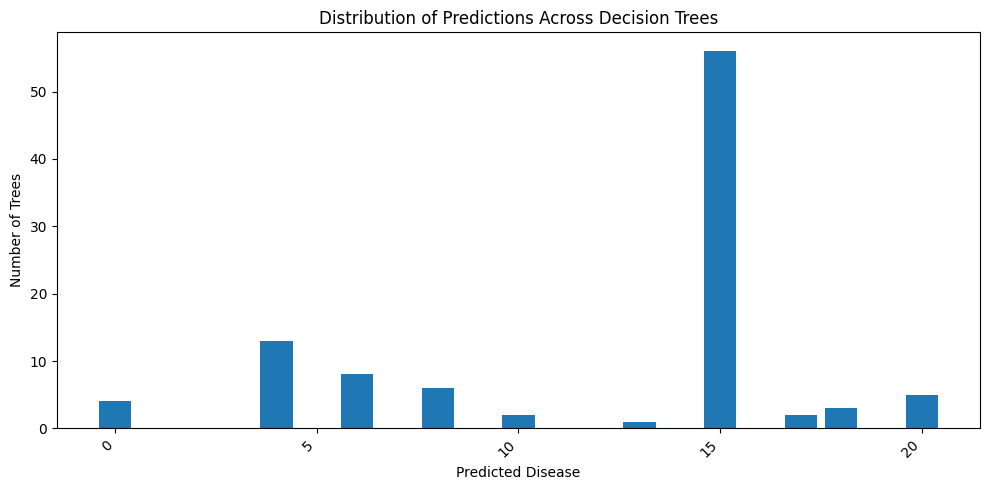

In [21]:
# Function to analyze individual tree predictions
def analyze_tree_predictions(symptoms):
    """Analyze predictions from individual trees in the forest"""
    # Preprocess and vectorize the input
    processed_symptoms = preprocess_text(symptoms)
    symptoms_vector = tfidf.transform([processed_symptoms])
    
    # Get predictions from all trees
    tree_predictions = []
    for tree in rf_model.estimators_:
        pred = tree.predict(symptoms_vector)[0]
        tree_predictions.append(pred)
    
    # Calculate prediction distribution
    unique_preds, counts = np.unique(tree_predictions, return_counts=True)
    distribution = dict(zip(unique_preds, counts))
    
    # Sort by count
    distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    
    return distribution

print("\nAnalyzing Individual Tree Predictions:")
print("-" * 50)
print("Symptoms:", example_symptom)
print("\nPrediction Distribution across Trees:")
tree_distribution = analyze_tree_predictions(example_symptom)
total_trees = len(rf_model.estimators_)

for disease, count in tree_distribution.items():
    percentage = (count / total_trees) * 100
    print(f"- {disease}: {count} trees ({percentage:.1f}%)")

# Visualize the distribution
plt.figure(figsize=(10, 5))
plt.bar(tree_distribution.keys(), tree_distribution.values())
plt.title('Distribution of Predictions Across Decision Trees')
plt.xlabel('Predicted Disease')
plt.ylabel('Number of Trees')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

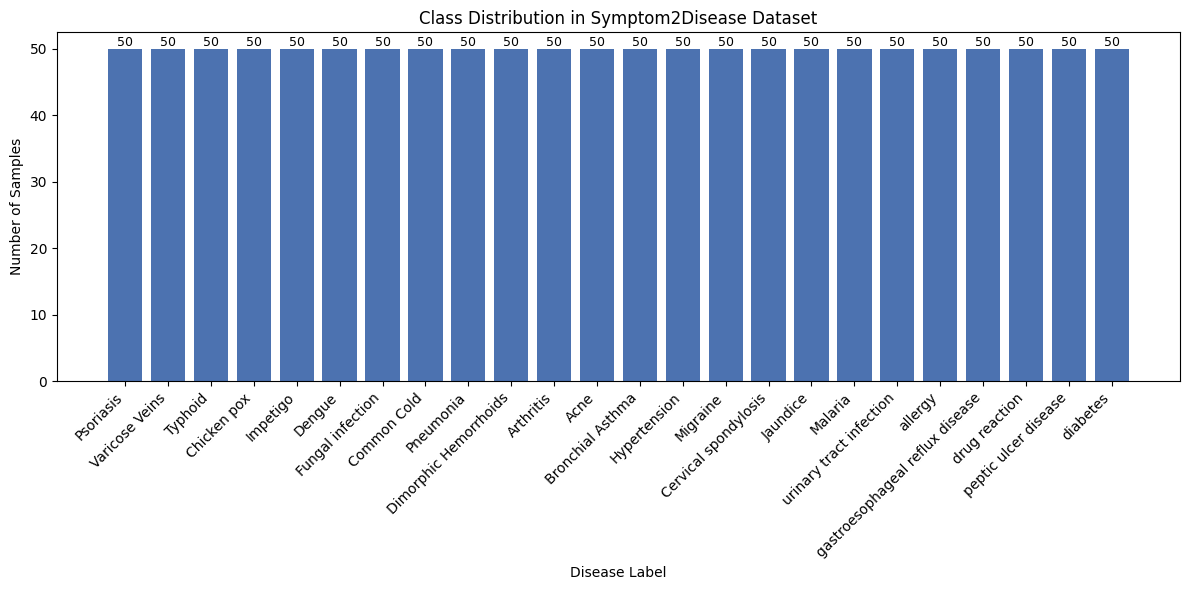

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure dataset is available
if 'df' not in globals() or 'label' not in df.columns:
    df = pd.read_csv('Symptom2Disease.csv')

# Compute class distribution
label_counts = df['label'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color="#4C72B0")
plt.title('Class Distribution in Symptom2Disease Dataset')
plt.xlabel('Disease Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')

# Annotate bars with counts
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
